### データの読み込み

In [51]:
import random
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

from src.datprep_i import DatPreprocess
from src.datasets import ThingsMEGDataset_aug1
#from src.models2 import BasicConvClassifier  # with glu
from src.utils import set_seed, set_lr, CosineScheduler

aug='_baseline_resize'
transform_train=DatPreprocess(aug_sel=aug)
#transform_valid=DatPreprocess(aug_sel=aug)
#transform_test=DatPreprocess(aug_sel=aug)

# ------------------
#    Dataloader
# ------------------
loader_args = {"batch_size": 64, "num_workers": 4, "pin_memory": True}

train_set = ThingsMEGDataset_aug1("train", 'data_spl', transform=transform_train)
val_set = ThingsMEGDataset_aug1("val", 'data_spl', transform=transform_train)
test_set = ThingsMEGDataset_aug1("test", 'data_spl', transform=transform_train)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, **loader_args)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, **loader_args)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, **loader_args)


In [52]:
len(train_set) #50000 pictures, 32x32xRGB pixels

16432

In [53]:
#Iter=iter(train_loader)
#batch1=next(Iter)
#print(batch1[0].shape, type(batch1[0]))

### 自己教師あり学習の実装

In [54]:
import math
import torch.nn as nn
import torch.optim as optim
from einops.layers.torch import Rearrange
from einops import rearrange

def fix_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


fix_seed(seed=42)

Attention

In [55]:
class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．埋め込み次元数と一致する．
        heads : int
            ヘッドの数．
        dim_head : int
            各ヘッドのデータの次元数．
        dropout : float
            Dropoutの確率(default=0.)．
        """
        super().__init__()

        self.dim = dim
        self.dim_head = dim_head
        inner_dim = dim_head * heads  # ヘッドに分割する前のQ, K, Vの次元数．self.dimと異なっても良い．
        project_out = not (heads == 1 and dim_head == dim)  # headsが1，dim_headがdimと等しければ通常のSelf-Attention

        self.heads = heads
        self.scale = math.sqrt(dim_head)  # ソフトマックス関数を適用する前のスケーリング係数(dim_k)

        self.attend = nn.Softmax(dim=-1)  # アテンションスコアの算出に利用するソフトマックス関数
        self.dropout = nn.Dropout(dropout)

        # Q, K, Vに変換するための全結合層
        self.to_q = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_k = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_v = nn.Linear(in_features=dim, out_features=inner_dim)

        # dim != inner_dimなら線形層を入れる，そうでなければそのまま出力
        self.to_out = nn.Sequential(
            nn.Linear(in_features=inner_dim, out_features=dim),
            nn.Dropout(dropout),
        ) if project_out else nn.Identity()

    def forward(self, x):
        """
        B: バッチサイズ
        N: 系列長
        D: データの次元数(dim)
        """
        B, N, D = x.size()

        # 入力データをQ, K, Vに変換する
        # (B, N, dim) -> (B, N, inner_dim)
        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)

        # Q, K, Vをヘッドに分割する
        # (B, N, inner_dim) -> (B, heads, N, dim_head)
        q = rearrange(q, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        k = rearrange(k, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        v = rearrange(v, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)

        # QK^T / sqrt(d_k)を計算する
        # (B, heads, N, dim_head) x (B, heads, dim_head, N) -> (B, heads, N, N)
        dots = torch.matmul(q, k.transpose(-2, -1)) / self.scale

        # ソフトマックス関数でスコアを算出し，Dropoutをする
        attn = self.attend(dots)
        attn = self.dropout(attn)

        # softmax(QK^T / sqrt(d_k))Vを計算する
        # (B, heads, N, N) x (B, heads, N, dim_head) -> (B, heads, N, dim_head)
        out = torch.matmul(attn ,v)

        # もとの形に戻す
        # (B, heads, N, dim_head) -> (B, N, dim)
        out = rearrange(out, "b h n d -> b n (h d)", h=self.heads, d=self.dim_head)

        # 次元が違っていればもとに戻して出力
        # 表現の可視化のためにattention mapも返すようにしておく
        return self.to_out(out), attn

In [56]:
attn = Attention(384, 12, 32, 0.) # dim, heads, dim_head, dropout
x = torch.rand(4, 64, 384)  # (Batch, N, Dim)
attn(x)[0].shape

torch.Size([4, 64, 384])

Feed-forward network
=multi layer perceptron

In [57]:
class FFN(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．
        hidden_dim : int
            隠れ層の次元．
        dropout : float
            各全結合層の後のDropoutの確率(default=0.)．
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=dim, out_features=hidden_dim),
            nn.GELU(), # Gaussian Error Linear Unit: ReLUに似た形状だがx=0で微分可能
            nn.Dropout(dropout),
            nn.Linear(in_features=hidden_dim, out_features=dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        """
        (B, D) -> (B, D)
        B: バッチサイズ
        D: 次元数
        """
        return self.net(x)

In [58]:
ffn = FFN(384, 768, 0.) # (dim, hidden_dim, dropout)
x = torch.rand(4, 64, 384)  # (Batch, N, Dim)
ffn(x).shape

torch.Size([4, 64, 384])

Transformer block

In [59]:
class Block(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout):
        """
        TransformerのEncoder Blockの実装．

        Arguments
        ---------
        dim : int
            埋め込みされた次元数．PatchEmbedのembed_dimと同じ値．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        dropout : float
            Droptou層の確率p．
        """
        super().__init__()

        self.attn_ln = nn.LayerNorm(dim)  # Attention前のLayerNorm
        self.attn = Attention(dim, heads, dim_head, dropout)
        self.ffn_ln = nn.LayerNorm(dim)  # FFN前のLayerNorm
        self.ffn = FFN(dim, mlp_dim, dropout)

    def forward(self, x, return_attn=False):
        """
        x: (B, N, dim)
        B: バッチサイズ
        N: 系列長
        dim: 埋め込み次元
        """
        y, attn = self.attn(self.attn_ln(x))
        if return_attn:  # attention mapを返す（attention mapの可視化に利用）
            return attn
        x = y + x
        out = self.ffn(self.ffn_ln(x)) + x

        return out

In [60]:
block = Block(384, 12, 32, 384, 0.) # (dim, heads, dim_head, mlp.dim, dropout)
x = torch.rand(4, 64, 384)  # (Batch, N, Dim)
block(x).shape

torch.Size([4, 64, 384])

Patch embedding

In [67]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
    #def __init__(self, image_size, patch_size, embed_dim):
        """
        入力画像をパッチごとに埋め込むための層．

        Arguments
        ---------
        image_size : Tuple[int]
            入力画像のサイズ．
        patch_size : Tuple[int]
            各パッチのサイズ．
        in_channels : int
            入力画像のチャネル数．
        embed_dim : int
            埋め込み後の次元数．
        """
        super().__init__()

        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, "パッチサイズは，入力画像のサイズを割り切れる必要があります．"

        num_patches = (image_height // patch_height) * (image_width // patch_width)  # パッチの数
        #patch_dim = patch_height * patch_width  # 各パッチを平坦化したときの次元数
        patch_dim = in_channels * patch_height * patch_width  # 各パッチを平坦化したときの次元数

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_height, p2=patch_width),  # 画像をパッチに分割して平坦化
            #Rearrange("b (h p1) (w p2) -> b (h w) (p1 p2)", p1=patch_height, p2=patch_width),  # 画像をパッチに分割して平坦化
            nn.Linear(in_features=patch_dim, out_features=embed_dim),  # 埋め込みを行う
        )

    def forward(self, x):
        """
        B: バッチサイズ
        C: 入力画像のチャネル数
        H: 入力画像の高さ
        W: 入力画像の幅
        """
        return self.to_patch_embedding(x)  # (B, C, H, W) -> (B, num_patches, embed_dim)


In [69]:
#patch_emb = PatchEmbedding((48, 48), (4, 4), 3, 384) # (image_size, patch_size, in_channels, embed_dim)
patch_emb = PatchEmbedding((48, 48), (4, 4), 1, 384) # (image_size, patch_size, in_channels, embed_dim)  # changed
#x = torch.rand((4, 3, 48, 48))  # (Batch, Channel, Height, Width)
x = torch.rand((4, 1, 48, 48))  # (Batch, Channel, Height, Width)  # changed
patch_emb(x).shape # (4 Batch, 8x8 patches, 384 embed_dim)

torch.Size([4, 144, 384])

Masked autoencoder

In [70]:
def random_indexes(size):
    """
    パッチをランダムに並べ替えるためのindexを生成する関数．

    Argument
    --------
    size : int
        入力されるパッチの数（系列長Nと同じ値）．
    """
    forward_indexes = np.arange(size)  # 0からsizeまでを並べた配列を作成
    np.random.shuffle(forward_indexes)  # 生成した配列をシャッフルすることで，パッチの順番をランダムに決定
    backward_indexes = np.argsort(forward_indexes)  # 並べ替えたパッチをもとの順番に戻すためのidx

    return forward_indexes, backward_indexes

In [71]:
x = np.random.randn((4))
forward_indexes, backward_indexes = random_indexes(x.shape[0])

print(f"original array: \n{x}")
print(f"forward indexes: \n{forward_indexes}\n{x[forward_indexes]}")  # ランダムに並べ替える
print(f"backward indexes: \n{backward_indexes}\n{x[forward_indexes][backward_indexes]}")  # 並べ替えた後にもとに戻す

original array: 
[ 0.49671415 -0.1382643   0.64768854  1.52302986]
forward indexes: 
[3 0 1 2]
[ 1.52302986  0.49671415 -0.1382643   0.64768854]
backward indexes: 
[1 2 3 0]
[ 0.49671415 -0.1382643   0.64768854  1.52302986]


In [72]:
def take_indexes(sequences, indexes):
    """
    パッチを並べ替えるための関数．

    Argument
    --------
    sequences : torch.Tensor
        入力画像をパッチ分割したデータ．(B, N, dim)の形状をしている．
    indexes : np.ndarray
        並べ替えるために利用するindex．
        random_indexesで生成したforward_indexesかbackward_indexesが入ることが想定されている．
    """
    # torch.gather: dim=1の時、indexで指定した位置の入力値を取ってきて並び替える
    return torch.gather(sequences, dim=1, index=indexes.unsqueeze(2).repeat(1, 1, sequences.shape[-1]))

In [73]:
class PatchShuffle(nn.Module):
    def __init__(self, ratio):
        # ratio: Encoderに入力しないパッチの割合
        super().__init__()
        self.ratio = ratio

    def forward(self, patches):
        """
        B: バッチサイズ
        N: 系列長（＝パッチの数）
        dim: 次元数（＝埋め込みの次元数）
        """
        B, N, dim = patches.shape
        remain_N = int(N * (1 - self.ratio))  # Encoderに入力するパッチの数

        indexes = [random_indexes(N) for _ in range(B)]  # バッチごとに異なる順番のindexを作る
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).T.to(patches.device)  # バッチを並べ替えるときのidx (B, N)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).T.to(patches.device)  # 並べ替えたパッチをもとの順番に戻すためのidx  (B, N)

        patches = take_indexes(patches, forward_indexes)  # パッチを並べ替える
        patches = patches[:, :remain_N, :]  # Encoderに入力するパッチを抽出

        return patches, forward_indexes, backward_indexes

In [74]:
x = torch.rand((4, 4, 8))  # (Batch, N, dim) 見やすいように小さい行列にしている
patch_shuffle = PatchShuffle(ratio=0.75)
in_patches, forward_idx, backward_idx = patch_shuffle(x)

print(f"original data: shape {x.shape} \n {x}")
print(f"encoder input data: shape {in_patches.shape} \n {in_patches}")

original data: shape torch.Size([4, 4, 8]) 
 tensor([[[0.8547, 0.0180, 0.9132, 0.1065, 0.6790, 0.6041, 0.8347, 0.5616],
         [0.9144, 0.7137, 0.0709, 0.4083, 0.8907, 0.4293, 0.2414, 0.8813],
         [0.0015, 0.8259, 0.1475, 0.6575, 0.8808, 0.0251, 0.4630, 0.2033],
         [0.3588, 0.5200, 0.2012, 0.7806, 0.7899, 0.8638, 0.2710, 0.4744]],

        [[0.0422, 0.3106, 0.7825, 0.1294, 0.0094, 0.3680, 0.3112, 0.4449],
         [0.0555, 0.6259, 0.6643, 0.3114, 0.2619, 0.6837, 0.7609, 0.9583],
         [0.2273, 0.2528, 0.0186, 0.5577, 0.9315, 0.3282, 0.6803, 0.4656],
         [0.8287, 0.7432, 0.9110, 0.9951, 0.8046, 0.9814, 0.4934, 0.9080]],

        [[0.4132, 0.3866, 0.1208, 0.1239, 0.1001, 0.5740, 0.7280, 0.5381],
         [0.4952, 0.4888, 0.8614, 0.7220, 0.2483, 0.7948, 0.7763, 0.2771],
         [0.4795, 0.2696, 0.0583, 0.0234, 0.9136, 0.5563, 0.9018, 0.2035],
         [0.9069, 0.6682, 0.6043, 0.5651, 0.5350, 0.6555, 0.7839, 0.6124]],

        [[0.8160, 0.4380, 0.2663, 0.4074, 0.5367,

In [75]:
class MAE_Encoder(nn.Module):
    def __init__(self, image_size=[290, 290], patch_size=[29, 29], emb_dim=192, num_layer=12,
                 heads=3, dim_head=64, mlp_dim=192, mask_ratio=0.75, dropout=0.):
        """
        Arguments
        ---------

        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        num_layer : int
            Encoderに含まれるBlockの数．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        mask_ratio : float
            入力パッチのマスクする割合．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()
        img_height, img_width = image_size
        patch_height, patch_width = patch_size
        num_patches = (img_height // patch_height) * (img_width // patch_width)

        self.cls_token = torch.nn.Parameter(torch.randn(1, 1, emb_dim))  # class tokenの初期化
        self.pos_embedding = torch.nn.Parameter(torch.randn(1, num_patches, emb_dim))  # positional embedding（学習可能にしている）
        self.shuffle = PatchShuffle(mask_ratio)

        # 入力画像をパッチに分割する
        #self.patchify = PatchEmbedding(image_size, patch_size, 3, emb_dim)
        self.patchify = PatchEmbedding(image_size, patch_size, 1, emb_dim)  # changed

        # Encoder（Blockを重ねる）
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])

        self.layer_norm = nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        torch.nn.init.normal_(self.cls_token, std=0.02)
        torch.nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, img):
        # 1. 入力画像をパッチに分割して，positional embeddingする
        patches = self.patchify(img)
        patches = patches + self.pos_embedding

        # 2. 分割したパッチをランダムに並べ替えて，必要なパッチのみ得る
        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        # class tokenを結合
        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)

        # 3. Encoderで入力データを処理する
        features = self.layer_norm(self.transformer(patches))

        return features, backward_indexes

In [76]:
encoder = MAE_Encoder()

#x = torch.rand((4, 3, 48, 48))  # (B, C, H, W)
x = torch.rand((4, 1, 290, 290))  # (B, C, H, W)  # changed
features, backward_indexes = encoder(x)

print(features.shape)

torch.Size([4, 26, 192])


In [77]:
class MAE_Decoder(nn.Module):
    def __init__(self, image_size=[290, 290], patch_size=[29, 29], emb_dim=192, num_layer=4,
                 heads=3, dim_head=64, mlp_dim=192, dropout=0.):
        """
        Arguments
        ---------

        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        num_layer : int
            Decoderに含まれるBlockの数．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()
        img_height, img_width = image_size
        patch_height, patch_width = patch_size
        num_patches = (img_height // patch_height) * (img_width // patch_width)

        self.mask_token = torch.nn.Parameter(torch.rand(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.rand(1, num_patches+1, emb_dim))

        # Decoder(Blockを重ねる）
        self.transformer = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])

        # 埋め込みされた表現から画像を復元するためのhead
        #self.head = torch.nn.Linear(emb_dim, 3 * patch_height * patch_width)
        self.head = torch.nn.Linear(emb_dim, 1 * patch_height * patch_width)  # changed
        # (B, N, dim)から(B, C, H, W)にreshapeするためのインスタンス
        self.patch2img = Rearrange("b (h w) (c p1 p2) -> b c (h p1) (w p2)", p1=patch_height, p2=patch_width, h=img_height // patch_height)
        #self.patch2img = Rearrange("b (h w) (p1 p2) -> b (h p1) (w p2)", p1=patch_height, p2=patch_width, h=img_height // patch_height)

        self.init_weight()

    def init_weight(self):
        torch.nn.init.normal_(self.mask_token, std=0.02)
        torch.nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, features, backward_indexes):
        # 系列長
        T = features.shape[1]

        # class tokenがある分backward_indexesの最初に0を追加する
        # .toはデバイスの変更でよく利用するが，tensorを渡すことでdtypeを変えることができる
        backward_indexes = torch.cat([torch.zeros(backward_indexes.shape[0], 1).to(backward_indexes), backward_indexes+1], dim=1)

        # 1. mask_tokenを結合して並べ替える．
        # (B, N*(1-mask_ratio)+1, dim) -> (B, N+1, dim)
        features = torch.cat([features, self.mask_token.repeat(features.shape[0], backward_indexes.shape[1] - features.shape[1], 1)], dim=1)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = self.transformer(features)

        # class tokenを除去する
        # (B, N+1, dim) -> (B, N, dim)
        features = features[:, 1:, :]

        # 2. 画像を再構成する．
        # (B, N, dim) -> (B, N, 3 * patch_height * patch_width)
        patches = self.head(features)

        # MAEではマスクした部分でのみ損失関数を計算するため，maskも一緒に返す
        mask = torch.zeros_like(patches)
        mask[:, T-1:] = 1  # cls tokenを含めていた分ずらしている
        mask = take_indexes(mask, backward_indexes[:, 1:] - 1)

        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

In [78]:
decoder = MAE_Decoder()
img, mask = decoder(features, backward_indexes)

print(img.shape)
print(mask.shape)

torch.Size([4, 1, 290, 290])
torch.Size([4, 1, 290, 290])


In [79]:
class MAE_ViT(nn.Module):
    def __init__(self, image_size=[290, 290], patch_size=[29, 29], emb_dim=192,
                 enc_layers=12, enc_heads=3, enc_dim_head=64, enc_mlp_dim=768,
                 dec_layers=4, dec_heads=3, dec_dim_head=64, dec_mlp_dim=768,
                 mask_ratio=0.75, dropout=0.):
        """
        Arguments
        ---------
        image_size : List[int]
            入力画像の大きさ．
        patch_size : List[int]
            各パッチの大きさ．
        emb_dim : int
            データを埋め込む次元の数．
        {enc/dec}_layers : int
            Encoder / Decoderに含まれるBlockの数．
        {enc/dec}_heads : int
            Encoder / DecoderのMulti-Head Attentionのヘッドの数．
        {enc/dec}_dim_head : int
            Encoder / DecoderのMulti-Head Attentionの各ヘッドの次元数．
        {enc/dec}_mlp_dim : int
            Encoder / DecoderのFeed-Forward Networkの隠れ層の次元数．
        mask_ratio : float
            入力パッチのマスクする割合．
        dropout : float
            ドロップアウトの確率．
        """
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, enc_layers,
                                   enc_heads, enc_dim_head, enc_mlp_dim, mask_ratio, dropout)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, dec_layers,
                                   dec_heads, dec_dim_head, dec_mlp_dim, dropout)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        rec_img, mask = self.decoder(features, backward_indexes)
        return rec_img, mask

    def get_last_selfattention(self, x):
        patches = self.encoder.patchify(x)
        patches = patches + self.encoder.pos_embedding

        patches = torch.cat([self.encoder.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        for i, block in enumerate(self.encoder.transformer):
            if i < len(self.encoder.transformer) - 1:
                patches = block(patches)
            else:
                return block(patches, return_attn=True)

In [80]:
mae = MAE_ViT()
#x = torch.rand((4, 3, 48, 48))  # (B, C, H, W)
x = torch.rand((4, 1, 290, 290))  # (B, C, H, W)  # changed
rec_img, mask = mae(x)

print(rec_img.shape)
print(mask.shape)

torch.Size([4, 1, 290, 290])
torch.Size([4, 1, 290, 290])


学習率スケジューラ

In [81]:
# cosine scheduler
class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr

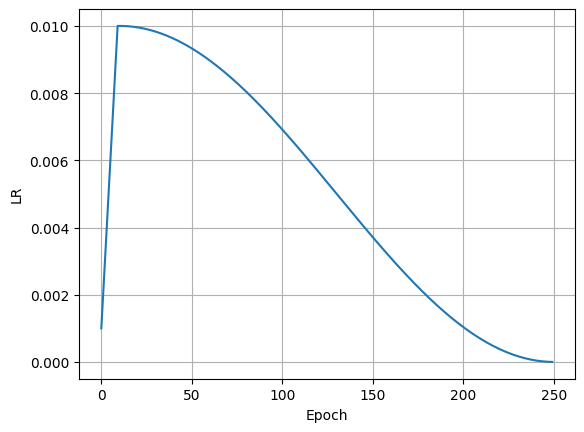

In [82]:
import matplotlib.pyplot as plt

scheduler = CosineScheduler(epochs=250, warmup_length=10, lr=0.01)
x = np.arange(250)
plt.plot(x, [scheduler(epoch) for epoch in x])
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)

plt.show()

学習率変更関数

In [83]:
def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [84]:
# ハイパーパラメータの設定
config = {
    "image_size": [290, 290],  # 271x281-->290x290
    "patch_size": [29, 29],  # 6x6-->29x29
    "emb_dim": 128,
    "enc_layers": 12,
    "enc_heads": 4,
    "enc_dim_head": 128,
    "enc_mlp_dim": 128,
    "dec_layers": 4,
    "dec_heads": 4,
    "dec_dim_head": 64,
    "dec_mlp_dim": 64,
    "mask_ratio": 0.75,
    "dropout": 0.
}

In [85]:
# モデルの定義
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MAE_ViT(**config).to(device)
epochs = 20
lr = 0.024
warmup_length=int(epochs*0.05)
#batch_size = 512
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.05)
scheduler = CosineScheduler(epochs, lr, warmup_length)
step_count = 0

### 事前学習（自己教師あり学習）

In [86]:
model_path="./model/pretrain_meg_01.pth"
model_w_path="./model/pretrain_meg_w_01.pth"

In [87]:
run_1st=True
if run_1st==True:
    for epoch in range(epochs):
        # スケジューラで学習率を更新する
        new_lr = scheduler(epoch)
        set_lr(new_lr, optimizer)

        total_train_loss = 0.
        total_valid_loss = 0.

        scaler = torch.cuda.amp.GradScaler()  # added
        # モデルの訓練
        for x, _ in tqdm(train_loader, desc="Train"):
            step_count += 1
            model.train()
            x = x.to(device)

            with torch.cuda.amp.autocast():  # added
                rec_img, mask = model(x)
                train_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

            #train_loss.backward()
            scaler.scale(train_loss).backward()

            #if step_count % 8 == 0:  # 8イテレーションごとに更新することで，擬似的にバッチサイズを大きくしている
            scaler.step(optimizer)
            #optimizer.step()
            optimizer.zero_grad()

            total_train_loss += train_loss.item()

            scaler.update()  #added

        # モデルの評価
        with torch.no_grad():
            for x, _ in tqdm(val_loader, desc="Valid"):
                model.eval()

                with torch.no_grad():
                    x = x.to(device)

                    rec_img, mask = model(x)
                    valid_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

                    total_valid_loss += valid_loss.item()


        print(f"Epoch[{epoch+1} / {epochs}] Train Loss: {total_train_loss/len(train_loader):.4f} Valid Loss: {total_valid_loss/len(val_loader):.4f}")
        if epoch%50==0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': total_train_loss,
                    'valid_loss': total_valid_loss,
                    }, model_w_path)
    # モデルを保存しておく
    torch.save(model.state_dict(), model_path)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss,
            'valid_loss': total_valid_loss,
            }, model_w_path)

Valid: 100%|██████████| 65/65 [00:08<00:00,  7.40it/s]


Epoch[1 / 20] Train Loss: 153.9517 Valid Loss: 26.7296


Valid: 100%|██████████| 65/65 [00:08<00:00,  7.98it/s]


Epoch[2 / 20] Train Loss: 29.9336 Valid Loss: 0.0069


Valid: 100%|██████████| 65/65 [00:07<00:00,  8.19it/s]


Epoch[3 / 20] Train Loss: 6.4472 Valid Loss: 1.8429


Valid: 100%|██████████| 65/65 [00:08<00:00,  8.09it/s]


Epoch[4 / 20] Train Loss: 1.9152 Valid Loss: 0.7223


Valid: 100%|██████████| 65/65 [00:07<00:00,  8.19it/s]


Epoch[5 / 20] Train Loss: 0.5557 Valid Loss: 0.0117


Valid: 100%|██████████| 65/65 [00:07<00:00,  8.35it/s]


Epoch[6 / 20] Train Loss: 0.0665 Valid Loss: 0.0061


Valid: 100%|██████████| 65/65 [00:07<00:00,  8.25it/s]


Epoch[7 / 20] Train Loss: 0.0890 Valid Loss: 0.0063


Valid: 100%|██████████| 65/65 [00:08<00:00,  7.99it/s]


Epoch[8 / 20] Train Loss: 0.7368 Valid Loss: 0.0051


Valid: 100%|██████████| 65/65 [00:07<00:00,  8.85it/s]


Epoch[9 / 20] Train Loss: 0.0173 Valid Loss: 0.0033


Valid: 100%|██████████| 65/65 [00:07<00:00,  9.24it/s]


Epoch[10 / 20] Train Loss: 0.0184 Valid Loss: 0.0032


Valid: 100%|██████████| 65/65 [00:43<00:00,  1.48it/s]


Epoch[11 / 20] Train Loss: 0.0050 Valid Loss: 0.0035


Valid: 100%|██████████| 65/65 [00:06<00:00,  9.64it/s]


Epoch[12 / 20] Train Loss: 0.0036 Valid Loss: 0.0032


Valid: 100%|██████████| 65/65 [00:06<00:00,  9.87it/s]


Epoch[13 / 20] Train Loss: 0.0032 Valid Loss: 0.0038


Valid: 100%|██████████| 65/65 [00:06<00:00,  9.54it/s]


Epoch[14 / 20] Train Loss: 0.0032 Valid Loss: 0.0032


Valid: 100%|██████████| 65/65 [00:06<00:00,  9.93it/s]


Epoch[15 / 20] Train Loss: 0.0031 Valid Loss: 0.0032


Valid: 100%|██████████| 65/65 [00:06<00:00,  9.63it/s]


Epoch[16 / 20] Train Loss: 0.0031 Valid Loss: 0.0031


Valid: 100%|██████████| 65/65 [00:06<00:00,  9.75it/s]


Epoch[17 / 20] Train Loss: 0.0031 Valid Loss: 0.0032


Valid: 100%|██████████| 65/65 [00:06<00:00,  9.79it/s]


Epoch[18 / 20] Train Loss: 0.0031 Valid Loss: 0.0031


Valid: 100%|██████████| 65/65 [00:06<00:00,  9.90it/s]


Epoch[19 / 20] Train Loss: 0.0031 Valid Loss: 0.0031


Valid: 100%|██████████| 65/65 [00:06<00:00,  9.82it/s]


Epoch[20 / 20] Train Loss: 0.0031 Valid Loss: 0.0031


restart

In [88]:
run_2nd=False
if run_2nd==True:
    model = MAE_ViT(**config).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.05)

    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    t_loss = checkpoint['train_loss']
    v_loss = checkpoint['valid_loss']

    for epoch in range(epoch, epochs):
        # スケジューラで学習率を更新する
        new_lr = scheduler(epoch)
        set_lr(new_lr, optimizer)

        total_train_loss = 0.
        total_valid_loss = 0.

        scaler = torch.cuda.amp.GradScaler()  # added
        # モデルの訓練
        for x, _ in train_loader:
            step_count += 1
            model.train()
            x = x.to(device)

            with torch.cuda.amp.autocast():  # added
                rec_img, mask = model(x)
                train_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

            #train_loss.backward()
            scaler.scale(train_loss).backward()

            #if step_count % 8 == 0:  # 8イテレーションごとに更新することで，擬似的にバッチサイズを大きくしている
            scaler.step(optimizer)
            #optimizer.step()
            optimizer.zero_grad()

            total_train_loss += train_loss.item()

            scaler.update()

        # モデルの評価
        with torch.no_grad():
            for x, _ in val_loader:
                model.eval()

                with torch.no_grad():
                    x = x.to(device)

                    rec_img, mask = model(x)
                    valid_loss = torch.mean((rec_img - x) ** 2 * mask) / config["mask_ratio"]

                    total_valid_loss += valid_loss.item()


        print(f"Epoch[{epoch+1} / {epochs}] Train Loss: {total_train_loss/len(train_loader):.4f} Valid Loss: {total_valid_loss/len(val_loader):.4f}")
        if epoch%50==0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': total_train_loss,
                    'valid_loss': total_valid_loss,
                    }, model_w_path)
    # モデルを保存しておく
    torch.save(model.state_dict(), model_path)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss,
            'valid_loss': total_valid_loss,
            }, model_w_path)


保存したモデルで推論

In [89]:
model = MAE_ViT(**config).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()
x, _ = next(iter(val_loader))
with torch.no_grad():
    rec_img, mask = model(x.to(device))

x, rec_img, mask = x.to("cpu"), rec_img.to("cpu"), mask.to("cpu")

推論結果の描画

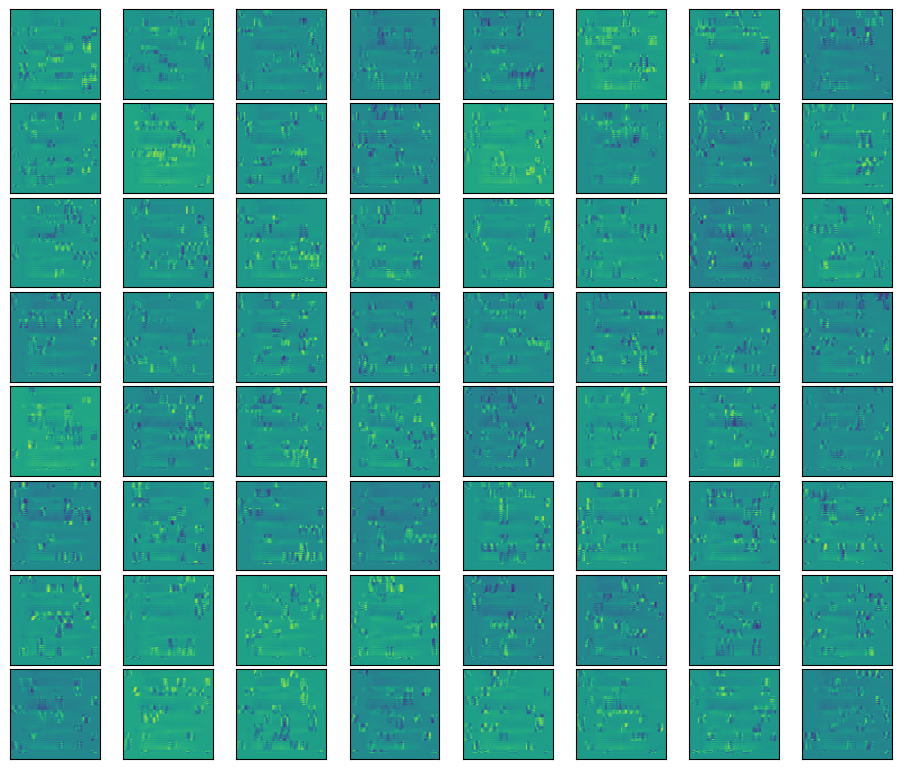

In [90]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

# MAEの出力そのままを可視化する場合
# imgs = rec_img

# マスクしていた部分は元の画像を用いる
imgs = rec_img * mask + x * (1 - mask)
imgs = (imgs.data + 1) / 2  # 標準化した状態から0-1に戻す
i = 0
for img in imgs[:64]:
    # 出力が線形変換のため0-1になっているとは限らないためclipする
    #img = np.clip(np.transpose(torch.squeeze(img).numpy(), (1, 2, 0)), 0, 1)
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (0, 1)), 0, 1)
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(img)
    i += 1

元画像の描画

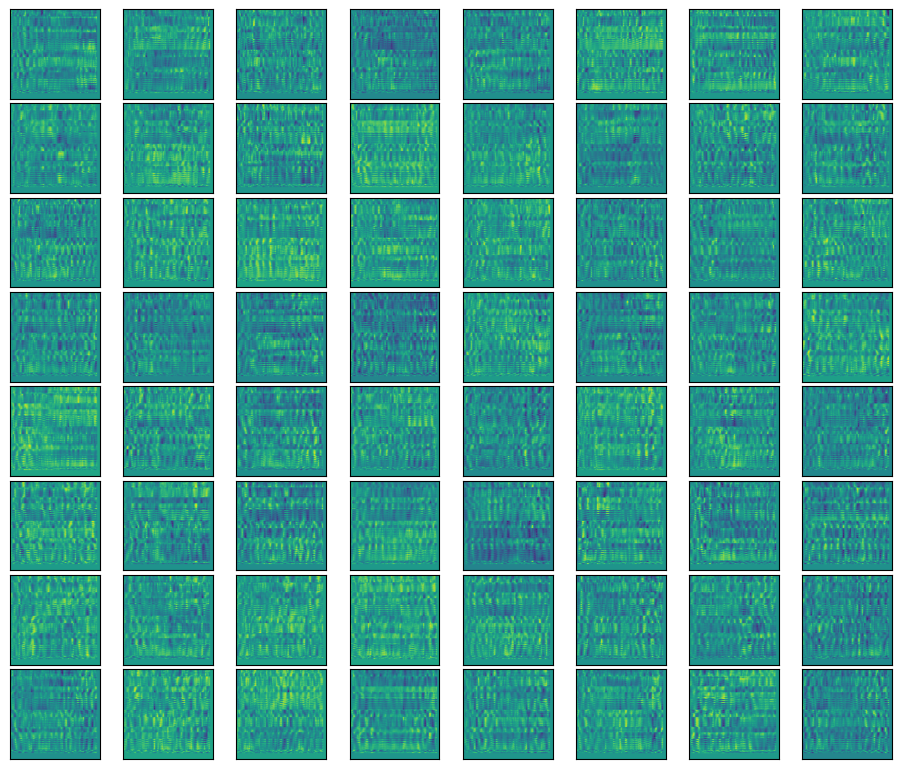

In [91]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
imgs = (x.data + 1) / 2
for img in imgs[:64]:
    #img = np.clip(np.transpose(torch.squeeze(img).numpy(), (1, 2, 0)), 0, 1)
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (0, 1)), 0, 1)
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(img)
    i += 1

Attention mapの可視化

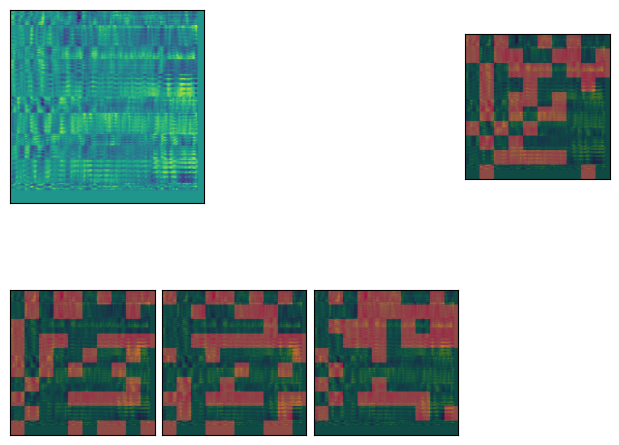

In [92]:
def display_attn_map(model, x):
    # Encoderの最後のattention mapを取得
    attn = model.get_last_selfattention(x[0].unsqueeze(0).to(device))

    # Nはパッチの数
    # (1, num_head, N+1, N+1) -> (num_head, N)
    num_head = config["enc_heads"]
    attn = attn[0, :, 0, 1:].reshape(num_head, -1)  # cls tokenに対するスコアを抽出

    val, idx = torch.sort(attn)  # スコアを昇順でソート
    val /= torch.sum(val, dim=1, keepdim=True)  # スコアを[0-1]で正規化する

    # 累積和をとりスコアの合計が0.6ほどになるように残す
    cumval = torch.cumsum(val, dim=1)
    attn = cumval > (1 - 0.4)
    backward_indexes = torch.argsort(idx)

    # ソートしたものを戻す
    for head in range(num_head):
        attn[head] = attn[head][backward_indexes[head]]

    # スコアを画像の形にする
    w_featmap, h_featmap = config["image_size"][0] // config["patch_size"][0], config["image_size"][1] // config["patch_size"][1]
    attn = attn.reshape(num_head, h_featmap, w_featmap).float()

    # 入力画像と同じ大きさにする
    attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=config["patch_size"][0], mode="nearest")[0].detach().cpu().numpy()

    # 入力画像とヘッドごとのattention mapを出力する
    fig = plt.figure(figsize=(6, 10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                        wspace=0.05)

    img = (x[0].data + 1) / 2
    #img = np.clip(np.transpose(torch.squeeze(img).numpy(), (1, 2, 0)), 0, 1)
    img = np.clip(np.transpose(torch.squeeze(img).numpy(), (0, 1)), 0, 1)
    ax = fig.add_subplot(2, 3, 1, xticks=[], yticks=[])
    ax.imshow(img)

    for i in range(len(attn)):
        featmap = attn[i]
        #featmap = np.concatenate((featmap[:,:,np.newaxis], np.zeros((48, 48, 2))), axis=2)
        featmap = np.concatenate((featmap[:,:,np.newaxis], np.zeros((290, 290, 2))), axis=2)
        ax = fig.add_subplot(2, 4, i+4, xticks=[], yticks=[])
        ax.imshow(img)
        ax.imshow(featmap, alpha=0.5)


model = MAE_ViT(**config).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
x, _ = next(iter(val_loader))  # 検証用データからデータを取得する

display_attn_map(model, x)

### Linear probing

In [93]:
aug='_baseline_resize'
transform_train=DatPreprocess(aug_sel=aug)

# ------------------
#    Dataloader
# ------------------
loader_args = {"batch_size": 64, "num_workers": 4, "pin_memory": True}

train_set = ThingsMEGDataset_aug1("train", 'data_spl', transform=transform_train)
val_set = ThingsMEGDataset_aug1("val", 'data_spl', transform=transform_train)
test_set = ThingsMEGDataset_aug1("test", 'data_spl', transform=transform_train)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, **loader_args)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, **loader_args)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, **loader_args)


クラス分類器

In [94]:
class Classifier(nn.Module):
    def __init__(self, encoder: MAE_Encoder, num_classes=1854):
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = patches + self.pos_embedding  # positional embedding

        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        features = self.layer_norm(self.transformer(patches))
        logits = self.head(features[:, 0])  # cls tokenのみを入力する
        return logits

    def get_last_selfattention(self, x):
        patches = self.patchify(x)
        patches = patches + self.pos_embedding

        patches = torch.cat([self.cls_token.repeat(patches.shape[0], 1, 1), patches], dim=1)  # class tokenを結合
        for i, block in enumerate(self.transformer):
            if i < len(self.transformer) - 1:
                patches = block(patches)
            else:
                return block(patches, return_attn=True)

In [95]:
# ハイパーパラメータの設定
config = {
    "image_size": [290, 290],
    "patch_size": [29, 29],
    "emb_dim": 128,
    "enc_layers": 12,
    "enc_heads": 4,
    "enc_dim_head": 128,
    "enc_mlp_dim": 128,
    "dec_layers": 4,
    "dec_heads": 4,
    "dec_dim_head": 64,
    "dec_mlp_dim": 64,
    "mask_ratio": 0.75,
    "dropout": 0.
}

In [96]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pretrained_model = MAE_ViT(**config).to(device)
pretrained_model.load_state_dict(torch.load(model_path, map_location=device))


encoder = pretrained_model.encoder

# モデルの定義
model = Classifier(encoder).to(device)

epochs = 20
lr = 0.005
warmup_length = int(epochs*0.05)
#batch_size = 128
optimizer = optim.AdamW(model.head.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.05)  # 分類器部分のみ学習
scheduler = CosineScheduler(epochs, lr, warmup_length)
criterion = nn.CrossEntropyLoss()

分類器の学習

In [97]:
class_path="./model/classifier_meg_01.pth"

In [98]:
for epoch in range(epochs):
    new_lr = scheduler(epoch)
    set_lr(new_lr, optimizer)

    total_train_loss = 0.
    total_train_acc = 0.
    total_valid_loss = 0.
    total_valid_acc = 0.
    scaler = torch.cuda.amp.GradScaler()  # added
    for x, t in tqdm(train_loader, desc="Train"):
        x, t = x.to(device), t.to(device)
        with torch.cuda.amp.autocast():  # added
            pred = model(x)
            train_loss = criterion(pred, t)

        train_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()

        optimizer.zero_grad()
        #train_loss.backward()
        scaler.scale(train_loss).backward()

        #optimizer.step()
        scaler.step(optimizer)

        total_train_loss += train_loss.item()
        total_train_acc += train_acc

        scaler.update()

    with torch.no_grad():
        for x, t in val_loader:
            x, t = x.to(device), t.to(device)
            pred = model(x)

            valid_loss = criterion(pred, t)
            valid_acc = (torch.argmax(pred, dim=1) == t).float().mean().cpu()

            total_valid_loss += valid_loss.item()
            total_valid_acc += valid_acc

    print(f"Epoch[{epoch+1} / {epochs}]",
          f"Train Loss: {total_train_loss/len(train_loader):.4f}",
          f"Train Acc.: {total_train_acc/len(train_loader):.4f}",
          f"Valid Loss: {total_valid_loss/len(val_loader):.4f}",
          f"Valid Acc.: {total_valid_acc/len(val_loader):.4f}")

torch.save(model.state_dict(), class_path)

Train: 100%|██████████| 257/257 [00:21<00:00, 11.90it/s]


Epoch[1 / 20] Train Loss: 7.7931 Train Acc.: 0.0004 Valid Loss: 7.5413 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.54it/s]


Epoch[2 / 20] Train Loss: 7.6433 Train Acc.: 0.0005 Valid Loss: 7.5450 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.63it/s]


Epoch[3 / 20] Train Loss: 7.6390 Train Acc.: 0.0008 Valid Loss: 7.5491 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.59it/s]


Epoch[4 / 20] Train Loss: 7.6412 Train Acc.: 0.0004 Valid Loss: 7.5470 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.58it/s]


Epoch[5 / 20] Train Loss: 7.6375 Train Acc.: 0.0008 Valid Loss: 7.5412 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.72it/s]


Epoch[6 / 20] Train Loss: 7.6309 Train Acc.: 0.0007 Valid Loss: 7.5350 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:19<00:00, 13.45it/s]


Epoch[7 / 20] Train Loss: 7.6218 Train Acc.: 0.0007 Valid Loss: 7.5317 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.78it/s]


Epoch[8 / 20] Train Loss: 7.6152 Train Acc.: 0.0005 Valid Loss: 7.5261 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.75it/s]


Epoch[9 / 20] Train Loss: 7.6084 Train Acc.: 0.0004 Valid Loss: 7.5189 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.81it/s]


Epoch[10 / 20] Train Loss: 7.5960 Train Acc.: 0.0005 Valid Loss: 7.5132 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:19<00:00, 13.42it/s]


Epoch[11 / 20] Train Loss: 7.5839 Train Acc.: 0.0005 Valid Loss: 7.5084 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.76it/s]


Epoch[12 / 20] Train Loss: 7.5737 Train Acc.: 0.0002 Valid Loss: 7.5027 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.98it/s]


Epoch[13 / 20] Train Loss: 7.5619 Train Acc.: 0.0002 Valid Loss: 7.4983 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.85it/s]


Epoch[14 / 20] Train Loss: 7.5483 Train Acc.: 0.0005 Valid Loss: 7.4961 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.86it/s]


Epoch[15 / 20] Train Loss: 7.5363 Train Acc.: 0.0003 Valid Loss: 7.4937 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.86it/s]


Epoch[16 / 20] Train Loss: 7.5250 Train Acc.: 0.0003 Valid Loss: 7.4931 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.94it/s]


Epoch[17 / 20] Train Loss: 7.5142 Train Acc.: 0.0006 Valid Loss: 7.4926 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.92it/s]


Epoch[18 / 20] Train Loss: 7.5052 Train Acc.: 0.0005 Valid Loss: 7.4924 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.93it/s]


Epoch[19 / 20] Train Loss: 7.4984 Train Acc.: 0.0005 Valid Loss: 7.4923 Valid Acc.: 0.0010


Train: 100%|██████████| 257/257 [00:18<00:00, 13.84it/s]


Epoch[20 / 20] Train Loss: 7.4941 Train Acc.: 0.0010 Valid Loss: 7.4923 Valid Acc.: 0.0010
